## Pos-Rppg Attempt 1 (Downsampling)

Notes: The ground truth files are still not match with the rppg signal

Time Performance:
- On Battery Saver = 8 min 4 sec
- On Charged Performance = 3 min 55 sec

In [1]:
## Import Dependencies
import numpy as np
import mediapipe as mp
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
from glob import glob
import scipy.signal as signal

In [2]:
## Open the Original Video
original_video = cv2.VideoCapture('../Samples/Original/vid_s53_T1.avi') # 35.14 Hz

## Open the Compressed Video
compressed_video = cv2.VideoCapture('../Samples/Compressed/compress_s53_T1.mp4') # 35.14 Hz

## Open the CSV Ground Truth Csv
ground_truth = pd.read_csv('../Samples/Original/bvp_s53_T1.csv', header=None).values.flatten() # 64 Hz

## Resampling the Ground Truth to match with the Frame Video Frame Rate

Since the difference in GT and Video, one way is to doing Upsampling Frame Video / Downsampling GT File. 

This method will focus on Downsampling first.

In [3]:
## Downsampling the ground truth to match on 35.14 Hz

# Original ground truth sampling rate
original_rate = 64.0  # Hz

# Target sampling rate
target_rate = 35  # Hz

# Calculate the number of samples after resampling
num_samples = int(len(ground_truth) * (target_rate / original_rate))

# Resample the ground truth data
downsampled_ground_truth = signal.resample(ground_truth, num_samples)

# Create a new DataFrame for the downsampled data
downsampled_ground_truth_df = pd.DataFrame(downsampled_ground_truth, columns=['BVP'])

## Show the downsampled ground truth length
print(f"Downsampled ground truth length: {len(downsampled_ground_truth)}")


Downsampled ground truth length: 6300


## Using POS (Plate Orthogonal to Skin) for the RPPG Technique to Estimate Heart Rate

- [Ref. Paper](https://pure.tue.nl/ws/files/31563684/TBME_00467_2016_R1_preprint.pdf)

In [4]:
## Core method Cpu POS 
def cpu_POS(signal, **kargs):
    """
    POS method on CPU using Numpy.

    The dictionary parameters are: {'fps':float}.

    Wang, W., den Brinker, A. C., Stuijk, S., & de Haan, G. (2016). Algorithmic principles of remote PPG. IEEE Transactions on Biomedical Engineering, 64(7), 1479-1491. 
    """
    """
    eps: A small constant (10^-9) used to prevent division by zero in normalization steps.
    X: The input signal, which is a 3D array where:
    e: Number of estimators or regions in the frame (like different parts of the face).
    c: Color channels (3 for RGB).
    f: Number of frames.
    w: Window length, determined by the camera's frame rate (fps). For example, at 20 fps, w would be 32 (which corresponds to about 1.6 seconds of video).
    """
    eps = 10**-9
    X = signal
    e, c, f = X.shape # Number of estimators, color channels, and frames
    w = int(1.6 * kargs['fps']) # Window length in frames

    """
    P: A fixed 2x3 matrix used for the projection step. It defines how to transform the color channels (RGB) into a new space.
    Q: This is a stack of the matrix P repeated e times, where each P corresponds to an estimator (region of interest) in the video.
    """
    P = np.array([[0, 1, -1], [-2, 1, 1]])
    Q = np.stack([P for _ in range(e)], axis = 0)

    """
    H: A matrix to store the estimated heart rate signal over time for each estimator.
    n: The current frame in the sliding window.
    m: The start index of the sliding window (calculating which frames are part of the current window).
    """
    H = np.zeros((e, f))
    for n in np.arange(w, f):
        # Start index of sliding window 
        m = n - w + 1

        """
        Temporal Normalization (Equation 5 from the paper): This step ensures that the signal is invariant to global lighting changes and other noise factors.
        """
        Cn = X[:, :, m:(n+1)]
        M = 1.0 / (np.mean(Cn, axis = 2) + eps)
        M = np.expand_dims(M, axis=2) # shape [e, c, w]
        Cn = np.multiply(Cn, M)

        """
        Projection (Equation 6 from the paper): This step transforms the RGB values into a space where the signal from blood flow (heart rate) is more distinct.
        """
        S = np.dot(Q, Cn)
        S = S[0, :, :, :]
        S = np.swapaxes(S, 0, 1) 

        """
        Tuning (Equation 7 from the paper): This step adjusts the projected components to make the heart rate signal clearer.
        """
        S1 = S[:, 0, :]
        S2 = S[:, 1, :]
        alpha = np.std(S1, axis=1) / (eps + np.std(S2, axis=1))
        alpha - np.expand_dims(alpha, axis=1)
        Hn = np.add(S1, alpha * S2)
        Hnm = Hn - np.expand_dims(np.mean(Hn, axis=1), axis=1)

        """
        Overlap-Adding (Equation 8 from the paper): This step combines the processed signals from each frame to form the final output heart rate signal.
        """
        H[:, m:(n + 1)] = np.add(H[:, m:(n + 1)], Hnm)  # Add the tuned signal to the output matrix

    return H

In [5]:
## Mediapipe Face Detection Initialization
mp_face_detection = mp.solutions.face_detection
face_detection = mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

### Working on the Original Video First

Theoretical: Since working with the entire 180 seconds video is resource intensive, working with the smaller bits first should be work well. My Approach is on the 20 first seconds.

In [6]:
## Since we've already the Original video on Cv2 Object, just prepare for the RPPG method

## original_video as the variable

# Prepare variables for the RPPG method
r_signal, g_signal, b_signal = [], [], []
f_count = 0
f_total = int(original_video.get(cv2.CAP_PROP_FRAME_COUNT))

In [7]:
"""
Our theoretical here, since the subject is moving along the video.
"""

## Main Loop 
try:
    while original_video.isOpened():
        print(f'Processing Frame {f_count}/{f_total}', end='\r')
        ret, frame = original_video.read()
        
        ### 3. Mendeteksi area wajah menggunakan mediapipe
        
        ### 3.1 Mengkonversi frame ke RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        ### 3.2 Memproses frame menggunakan face_detection
        results = face_detection.process(frame_rgb)
        
        if results.detections: # If there are faces detected
            for detection in results.detections: # Loop through all the detected faces
                ### 3.3 Mendapatkan bounding box dari wajah
                bbox = detection.location_data.relative_bounding_box
                ### 3.4 Mendapatkan lebar dan tinggi frame
                h, w, _ = frame.shape
                ### 3.5 Mengkonversi bounding box ke koordinat piksel
                x, y = int(bbox.xmin * w), int(bbox.ymin * h)
                ### 3.6 Mengkonversi lebar dan tinggi bounding box ke koordinat piksel
                width, height = int(bbox.width * w), int(bbox.height * h)
                
                # ### 3.7 Melakukan penyesuaian pada bounding box
                # bbox_size_from_center = 70
                
                # bbox_center_x = x + width // 2
                # bbox_center_y = y + height // 2
                # new_x = bbox_center_x - bbox_size_from_center
                # new_y = bbox_center_y - bbox_size_from_center
                # new_width = bbox_size_from_center * 2
                # new_height = bbox_size_from_center * 2
                
                ### 3.8 Menggambar bounding box pada frame
                # cv2.rectangle(frame, (new_x, new_y), (new_x + new_width, new_y + new_height), (0, 255, 0), 2)
                
                
                ### 4 Mendapatkan nilai rata-rata piksel dari ROI dan menambahkannya ke signal
                # roi = frame[new_y:new_y+new_height, new_x:new_x+new_width]
                # cv2.rectangle(frame, (x, y), (x + width, y + height), (0, 255, 0), 2)
                # roi = frame[y:y+height, x:x+width]
                # r_signal.append(np.mean(roi[:, :, 0]))
                # g_signal.append(np.mean(roi[:, :, 1]))
                # b_signal.append(np.mean(roi[:, :, 2]))
                                # Define forehead ROI
                forehead_x = x + width // 4  # Start slightly to the right of the left edge
                forehead_y = y // 2 + 55 # Start at the top of the bounding box
                forehead_width = width // 2  # Half the width of the bounding box
                forehead_height = height // 5  # Quarter the height of the bounding box
                
                # Extract the forehead ROI
                roi = frame[forehead_y:forehead_y+forehead_height, forehead_x:forehead_x+forehead_width]
                
                # Optional: Draw the forehead ROI on the frame for visualization
                cv2.rectangle(frame, 
                              (forehead_x, forehead_y), 
                              (forehead_x + forehead_width, forehead_y + forehead_height), 
                              (0, 255, 0), 2)

                # Calculate mean pixel values for the RGB channels
                r_signal.append(np.mean(roi[:, :, 0]))
                g_signal.append(np.mean(roi[:, :, 1]))
                b_signal.append(np.mean(roi[:, :, 2]))

        
        if not ret:
            break

        cv2.imshow('frame', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        
        f_count += 1
    original_video.release()
    cv2.destroyAllWindows()

except Exception as e:
    original_video.release()
    cv2.destroyAllWindows()

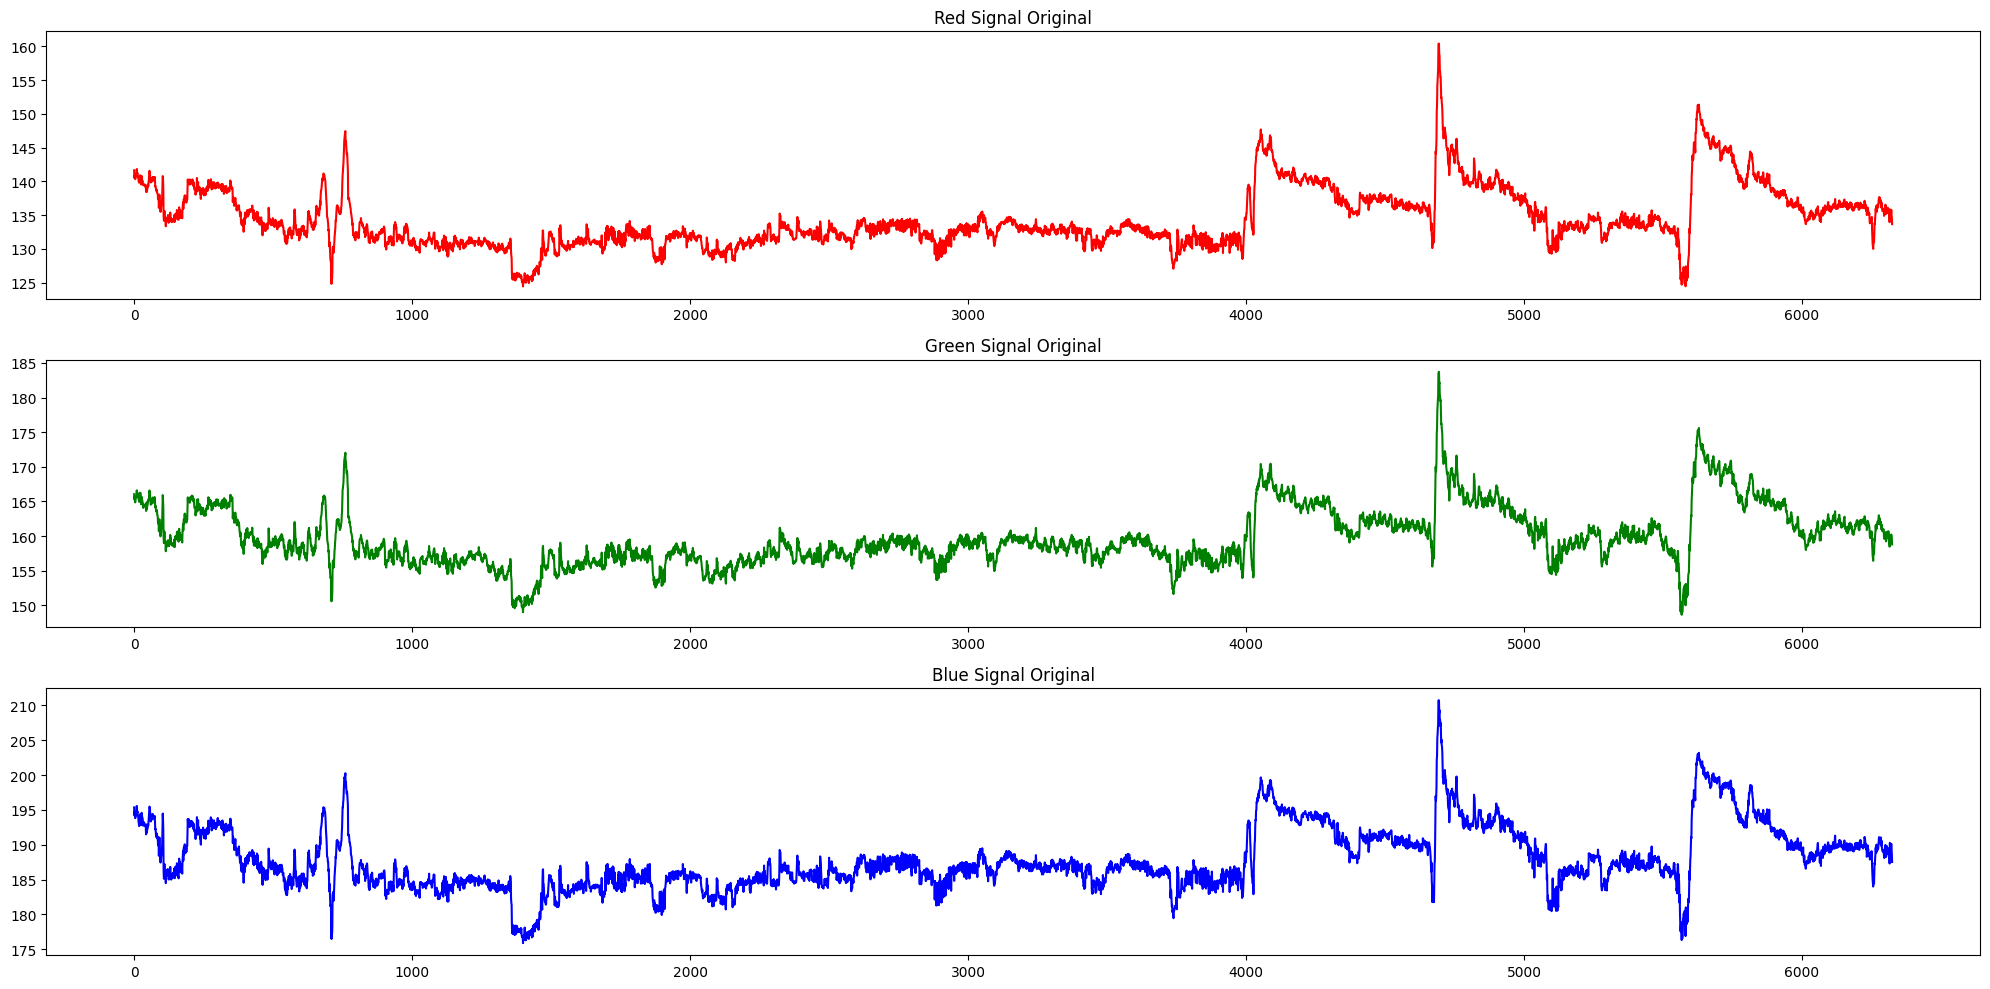

In [8]:
## Show the Signal Graph
ax, fig = plt.subplots(3, 1, figsize=(20, 10))
fig[0].plot(r_signal, color='red')
fig[0].set_title('Red Signal Original')
fig[1].plot(g_signal, color='green')
fig[1].set_title('Green Signal Original')
fig[2].plot(b_signal, color='blue')
fig[2].set_title('Blue Signal Original')
plt.tight_layout()
plt.show()

### Original RPPG Signal Method

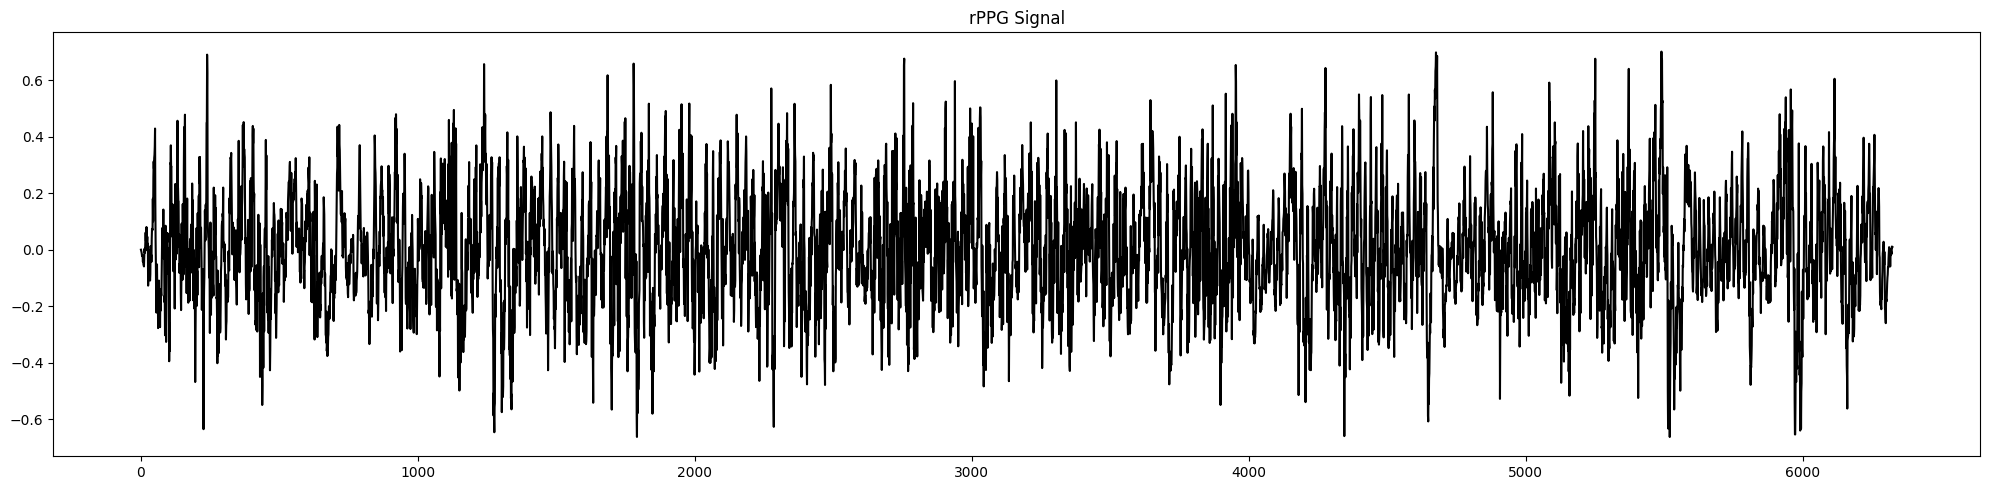

In [9]:
## Calculating the RPPG Signal
rgb_signals = np.array([r_signal, g_signal, b_signal])
rgb_signals = rgb_signals.reshape(1, 3, -1)
rppg_signal = cpu_POS(rgb_signals, fps=35)
rppg_signal = rppg_signal.reshape(-1)

# Show the RPPG Signal
plt.figure(figsize=(20, 5))
plt.plot(rppg_signal, color='black')
plt.title('rPPG Signal')
plt.tight_layout()
plt.show()

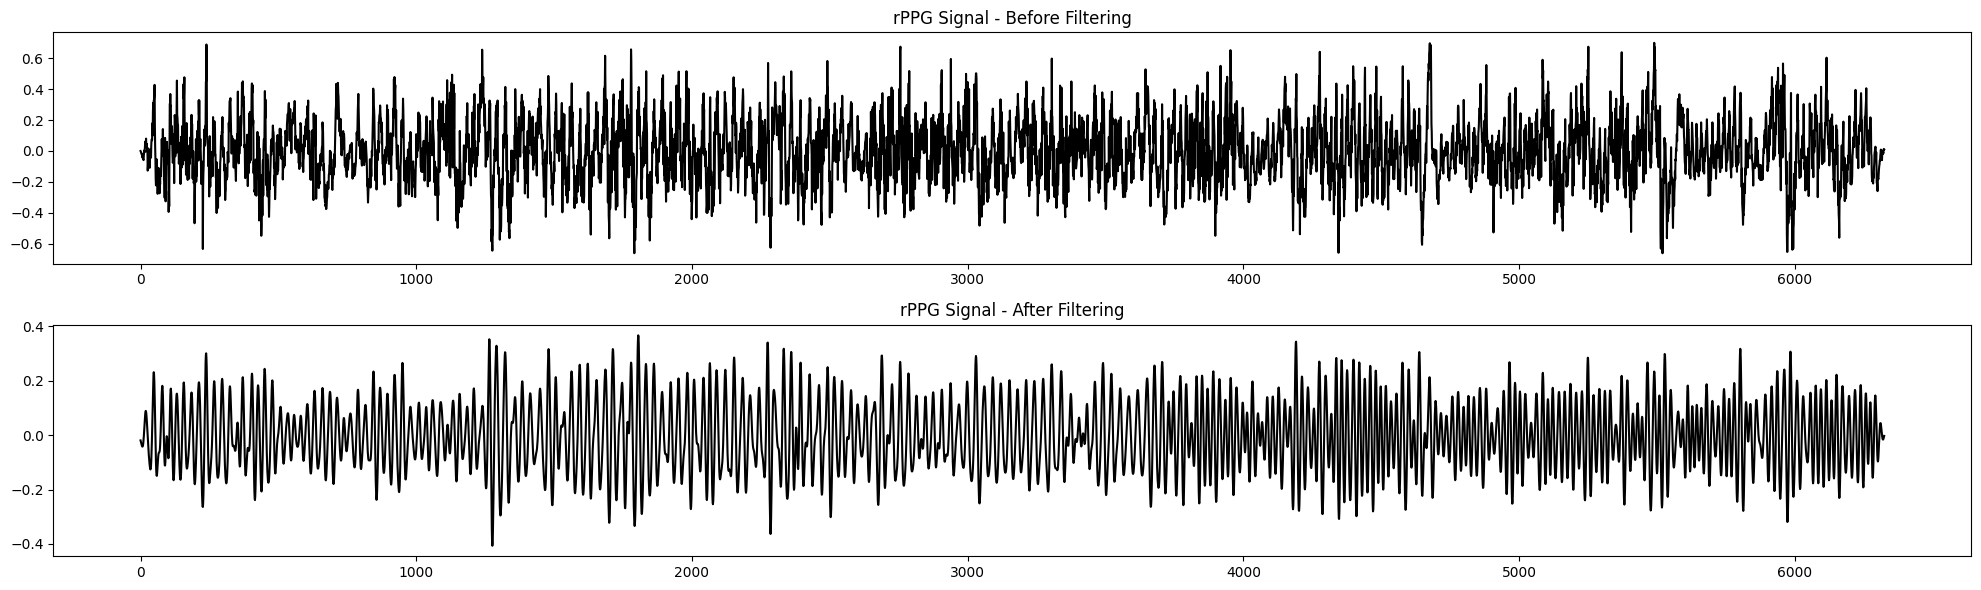

In [10]:
## Filter RPPG Signal
fs = 35; lowcut = 0.9; highcut = 2.4; order = 3
b, a = signal.butter(order, [lowcut, highcut], btype='band', fs=fs)
filtered_rppg = signal.filtfilt(b, a, rppg_signal)

## Show the Filtered RPPG Signal
fig, ax = plt.subplots(2, 1, figsize=(20, 6))
ax[0].plot(rppg_signal, color='black')
ax[0].set_title('rPPG Signal - Before Filtering')
ax[1].plot(filtered_rppg, color='black')
ax[1].set_title('rPPG Signal - After Filtering')
plt.tight_layout()
plt.show()

### Normalize and Finds Peak as the Heart Rate (QRS Complex)

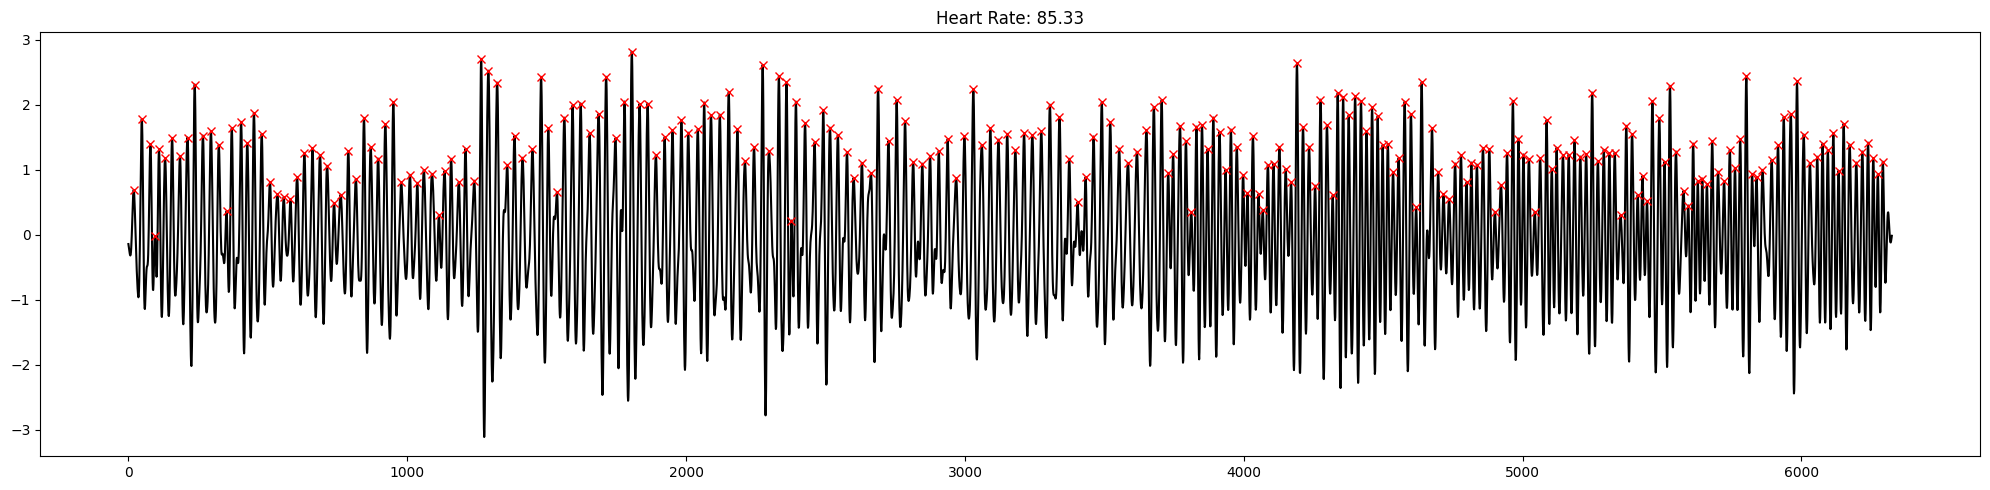

In [11]:
## Normalie the RPPG Signal
filtered_rppg = (filtered_rppg - np.mean(filtered_rppg)) / np.std(filtered_rppg)

## Finds Peak Signal
peaks, _ = signal.find_peaks(
    x=filtered_rppg,
    prominence=0.5,
)

## Calculating the Heart Rate and Show the Result
heart_rate = 60 * len(peaks) / (len(filtered_rppg) / fs)

plt.figure(figsize=(20, 5))
plt.plot(filtered_rppg, color='black')
plt.plot(peaks, filtered_rppg[peaks], 'x', color='red')
plt.title(f'Heart Rate: {heart_rate:.2f}')
plt.tight_layout()
plt.show()

### Working on the Compresed Video First

In [12]:
## Since we've already the Original video on Cv2 Object, just prepare for the RPPG method

## compressed_video as the variable

# Prepare variables for the RPPG method
compress_r_signal, comperss_g_signal, compress_b_signal = [], [], []
f_count = 0
f_total = int(compressed_video.get(cv2.CAP_PROP_FRAME_COUNT))

In [13]:
## Main Loop
"""
Our theoretical here, since the subject is moving along the video.
"""

## Main Loop 
try:
    while compressed_video.isOpened():
        print(f'Processing Frame {f_count}/{f_total}', end='\r')
        ret, frame = compressed_video.read()
        
        ### 3. Mendeteksi area wajah menggunakan mediapipe
        
        ### 3.1 Mengkonversi frame ke RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        ### 3.2 Memproses frame menggunakan face_detection
        results = face_detection.process(frame_rgb)
        
        if results.detections: # If there are faces detected
            for detection in results.detections: # Loop through all the detected faces
                ### 3.3 Mendapatkan bounding box dari wajah
                bbox = detection.location_data.relative_bounding_box
                ### 3.4 Mendapatkan lebar dan tinggi frame
                h, w, _ = frame.shape
                ### 3.5 Mengkonversi bounding box ke koordinat piksel
                x, y = int(bbox.xmin * w), int(bbox.ymin * h)
                ### 3.6 Mengkonversi lebar dan tinggi bounding box ke koordinat piksel
                width, height = int(bbox.width * w), int(bbox.height * h)
                
                ### 3.7 Melakukan penyesuaian pada bounding box
                # bbox_size_from_center = 70
                
                # bbox_center_x = x + width // 2
                # bbox_center_y = y + height // 2
                # new_x = bbox_center_x - bbox_size_from_center
                # new_y = bbox_center_y - bbox_size_from_center
                # new_width = bbox_size_from_center * 2
                # new_height = bbox_size_from_center * 2
                
                ### 3.8 Menggambar bounding box pada frame
                # cv2.rectangle(frame, (new_x, new_y), (new_x + new_width, new_y + new_height), (0, 255, 0), 2)
                
                # ### 4 Mendapatkan nilai rata-rata piksel dari ROI dan menambahkannya ke signal
                # roi = frame[new_y:new_y+new_height, new_x:new_x+new_width]
                # compress_r_signal.append(np.mean(roi[:, :, 0]))
                # comperss_g_signal.append(np.mean(roi[:, :, 1]))
                # compress_b_signal.append(np.mean(roi[:, :, 2]))
                forehead_x = x + width // 4  # Start slightly to the right of the left edge
                forehead_y = y // 2 + 55 # Start at the top of the bounding box
                forehead_width = width // 2  # Half the width of the bounding box
                forehead_height = height // 5  # Quarter the height of the bounding box
                
                # Extract the forehead ROI
                roi = frame[forehead_y:forehead_y+forehead_height, forehead_x:forehead_x+forehead_width]
                
                # Optional: Draw the forehead ROI on the frame for visualization
                cv2.rectangle(frame, 
                              (forehead_x, forehead_y), 
                              (forehead_x + forehead_width, forehead_y + forehead_height), 
                              (0, 255, 0), 2)

                # Calculate mean pixel values for the RGB channels
                compress_r_signal.append(np.mean(roi[:, :, 0]))
                comperss_g_signal.append(np.mean(roi[:, :, 1]))
                compress_b_signal.append(np.mean(roi[:, :, 2]))


        
        if not ret:
            break
        # cv2.imshow('frame', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        
        f_count += 1
    compressed_video.release()
    cv2.destroyAllWindows()

except Exception as e:
    compressed_video.release()
    cv2.destroyAllWindows()

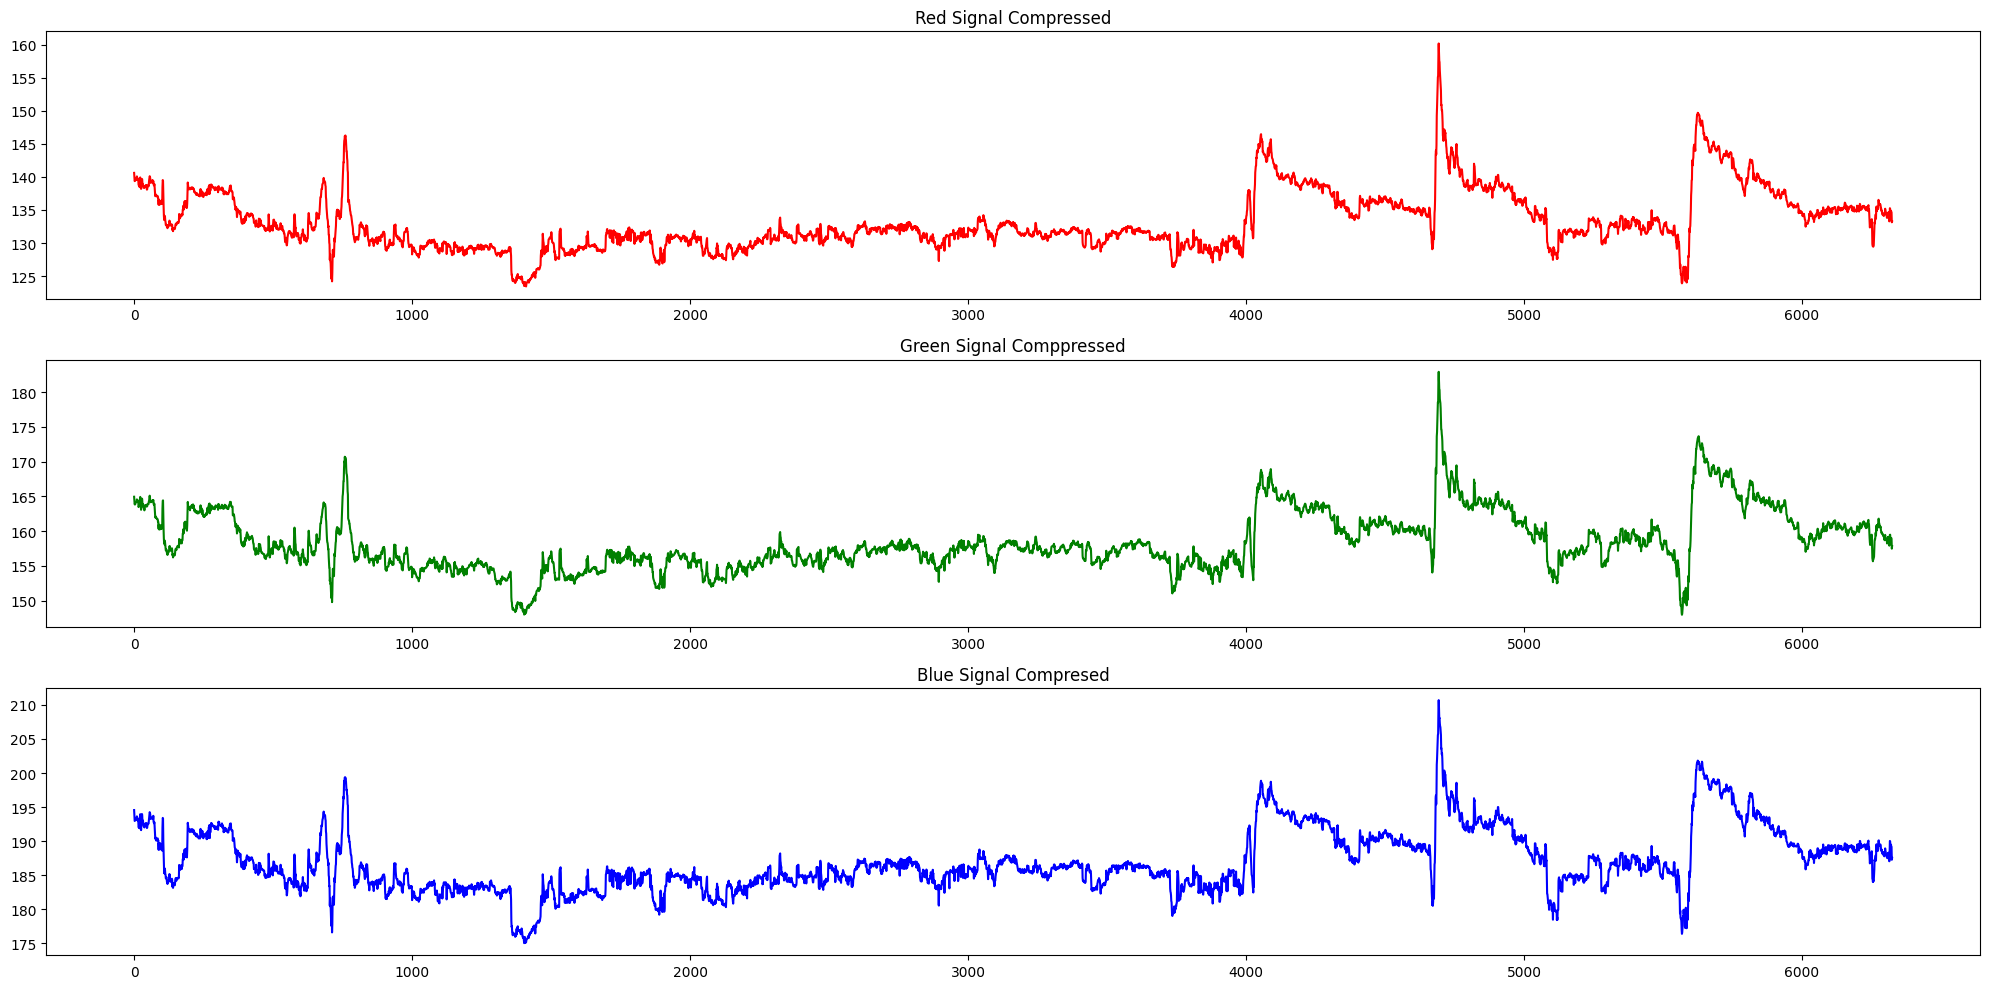

In [14]:
## Show the Signal Graph
ax, fig = plt.subplots(3, 1, figsize=(20, 10))
fig[0].plot(compress_r_signal, color='red')
fig[0].set_title('Red Signal Compressed')
fig[1].plot(comperss_g_signal, color='green')
fig[1].set_title('Green Signal Comppressed')
fig[2].plot(compress_b_signal, color='blue')
fig[2].set_title('Blue Signal Compresed')
plt.tight_layout()
plt.show()

### Compressed RPPG Signal Method

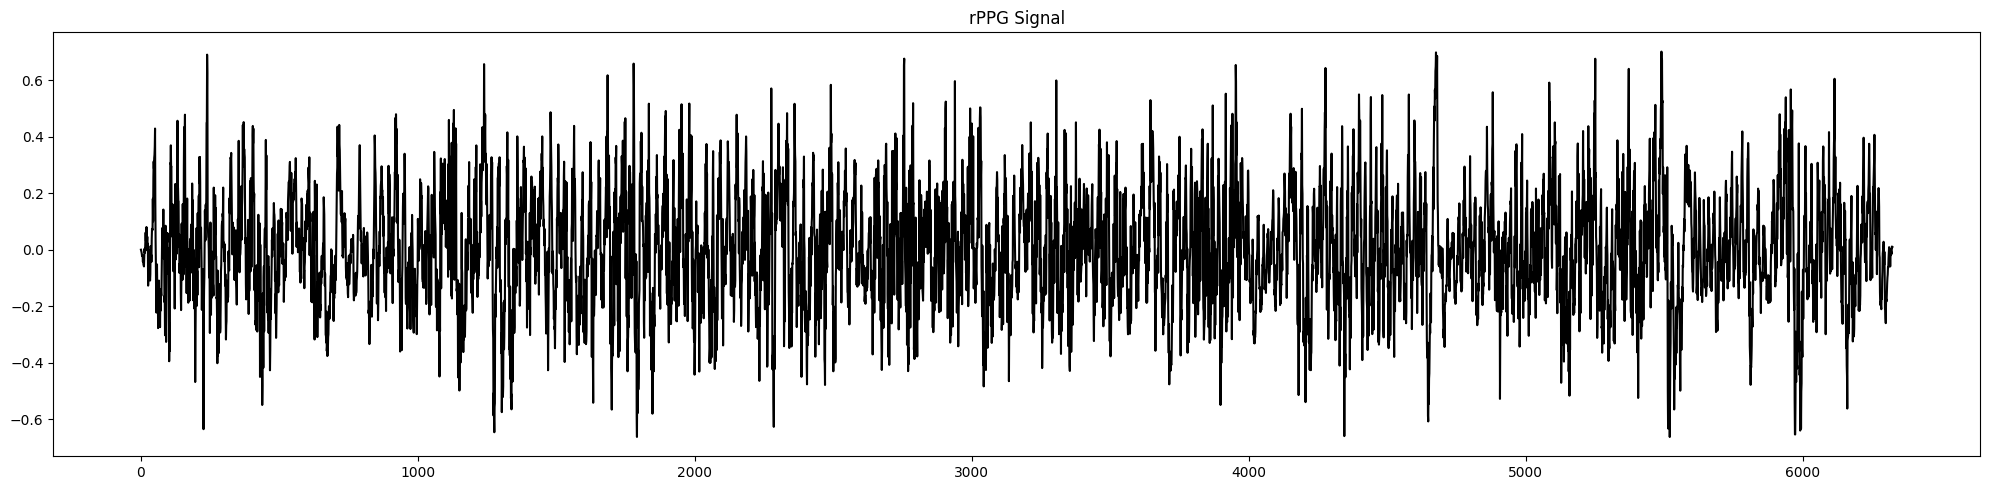

In [15]:
## Calculating the RPPG Signal
compress_rgb_signals = np.array([compress_r_signal, comperss_g_signal, compress_b_signal])
compress_rgb_signals = rgb_signals.reshape(1, 3, -1)
compress_rppg_signal = cpu_POS(rgb_signals, fps=35)
compress_rppg_signal = rppg_signal.reshape(-1)

# Show the RPPG Signal
plt.figure(figsize=(20, 5))
plt.plot(compress_rppg_signal, color='black')
plt.title('rPPG Signal')
plt.tight_layout()
plt.show()

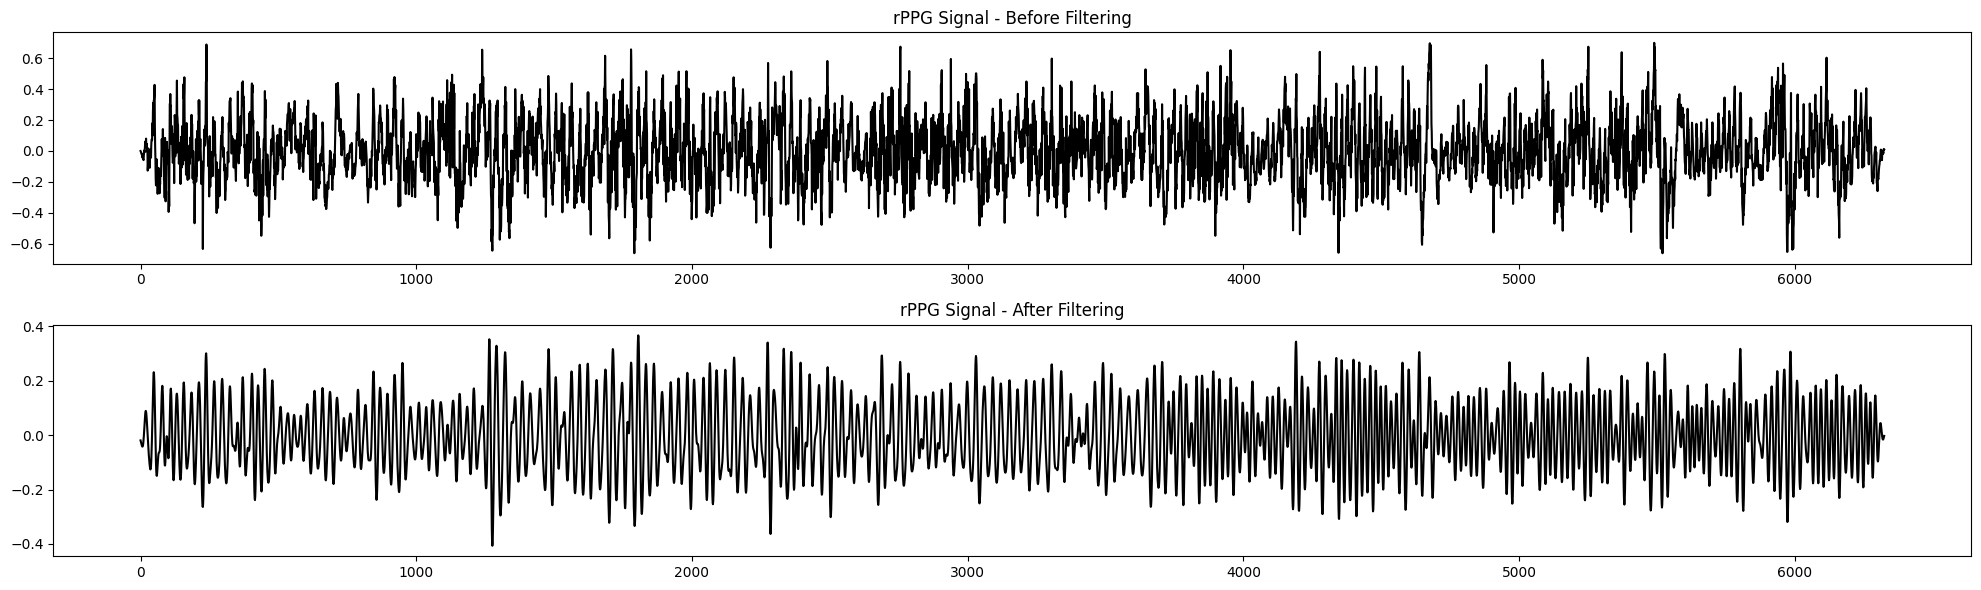

In [16]:
## Filter RPPG Signal
fs = 35; lowcut = 0.9; highcut = 2.4; order = 3
b, a = signal.butter(order, [lowcut, highcut], btype='band', fs=fs)
compressed_filtered_rppg = signal.filtfilt(b, a, compress_rppg_signal)

## Show the Filtered RPPG Signal
fig, ax = plt.subplots(2, 1, figsize=(20, 6))
ax[0].plot(compress_rppg_signal, color='black')
ax[0].set_title('rPPG Signal - Before Filtering')
ax[1].plot(compressed_filtered_rppg, color='black')
ax[1].set_title('rPPG Signal - After Filtering')
plt.tight_layout()
plt.show()

### Normalize and Finds Peak as the Heart Rate (QRS Complex)

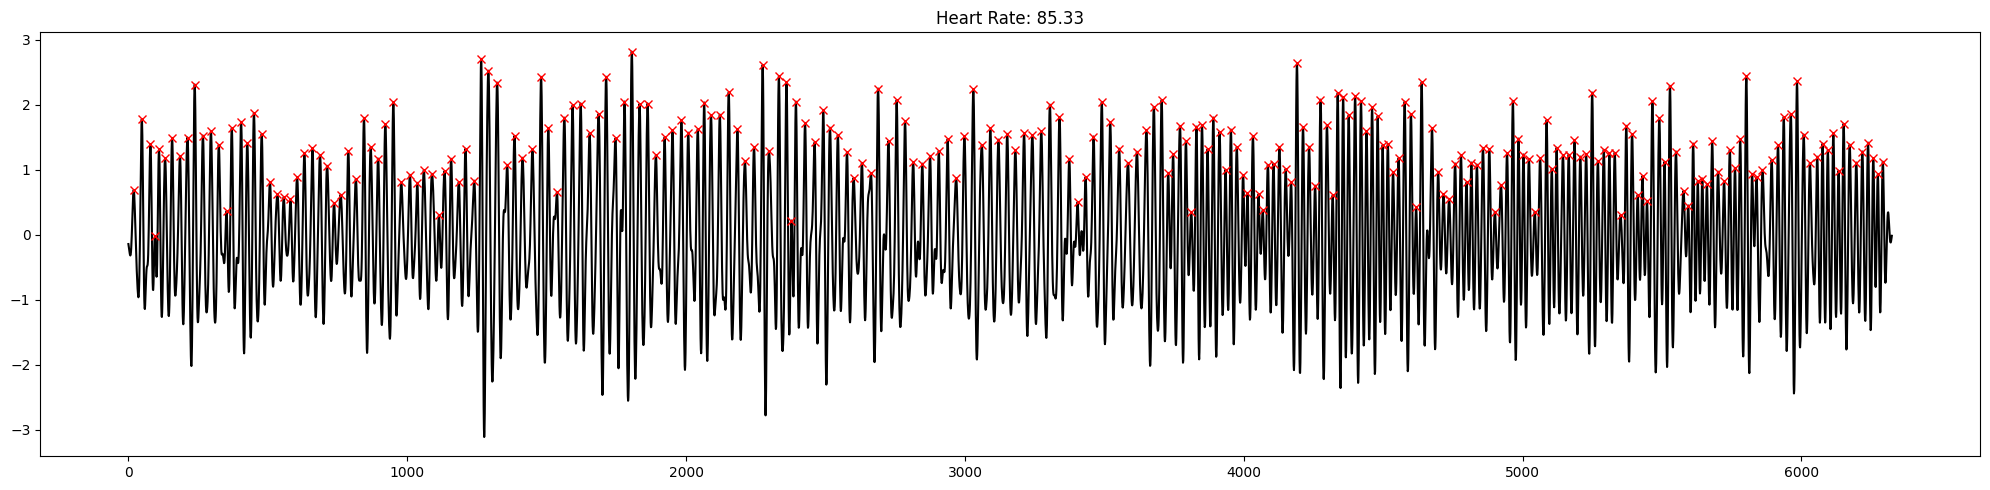

In [ ]:
## Normalize the RPPG Signal
compressed_filtered_rppg = (compressed_filtered_rppg - np.mean(compressed_filtered_rppg)) / np.std(compressed_filtered_rppg)

## Finds Peak Signal
peaks, _ = signal.find_peaks(
    x=compressed_filtered_rppg,
    prominence=0.5,
)

## Calculating the Heart Rate and Show the Result
heart_rate = 60 * len(peaks) / (len(compressed_filtered_rppg) / fs)

plt.figure(figsize=(20, 5))
plt.plot(compressed_filtered_rppg, color='black')
plt.plot(peaks, compressed_filtered_rppg[peaks], 'x', color='red')
plt.title(f'Heart Rate: {heart_rate:.2f}')
plt.tight_layout()
plt.show()

----

Well the Compresed and Original one Are look alike

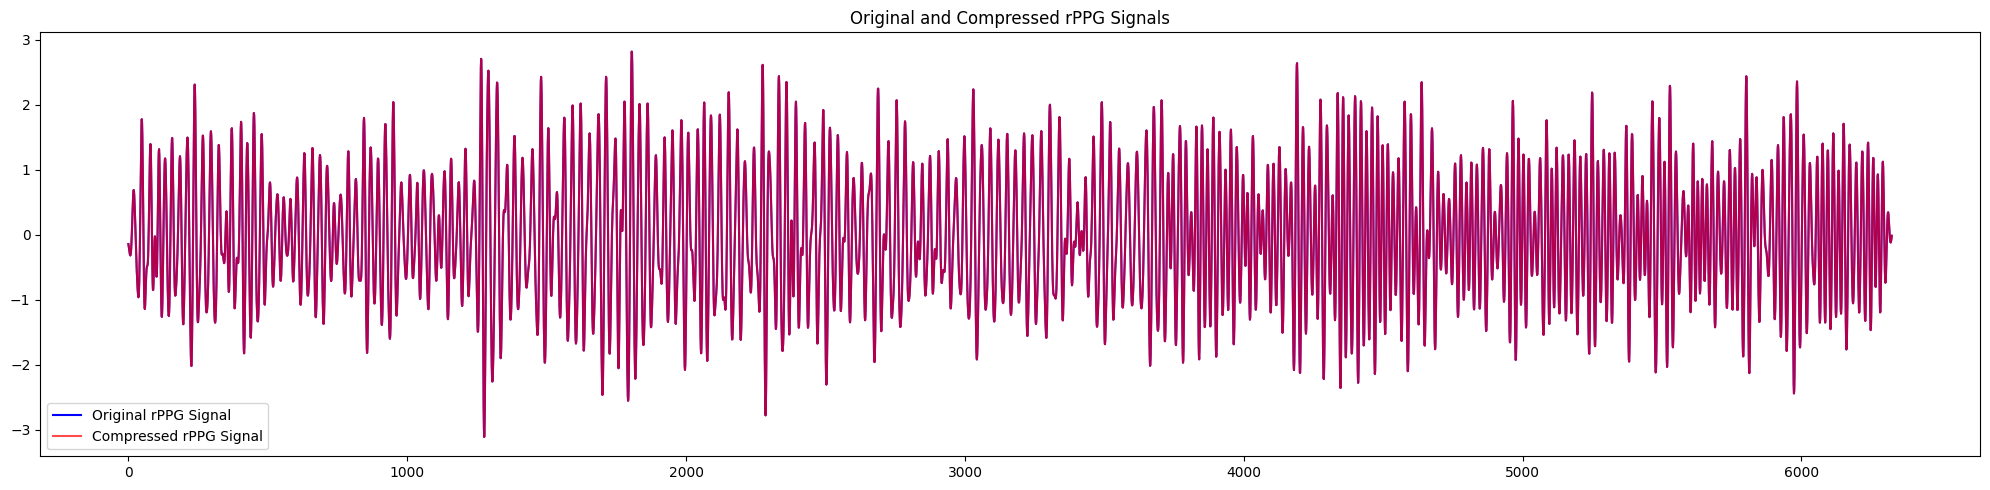

In [32]:
fig, ax = plt.subplots(figsize=(20, 5))

# Plot original signal
ax.plot(filtered_rppg, color='blue', label='Original rPPG Signal')

# Plot compressed signal
ax.plot(compressed_filtered_rppg, color='red', alpha=0.7, label='Compressed rPPG Signal')

ax.set_title('Original and Compressed rPPG Signals')
ax.legend()

plt.tight_layout()
plt.show()

### Working on Ground Truth Signal

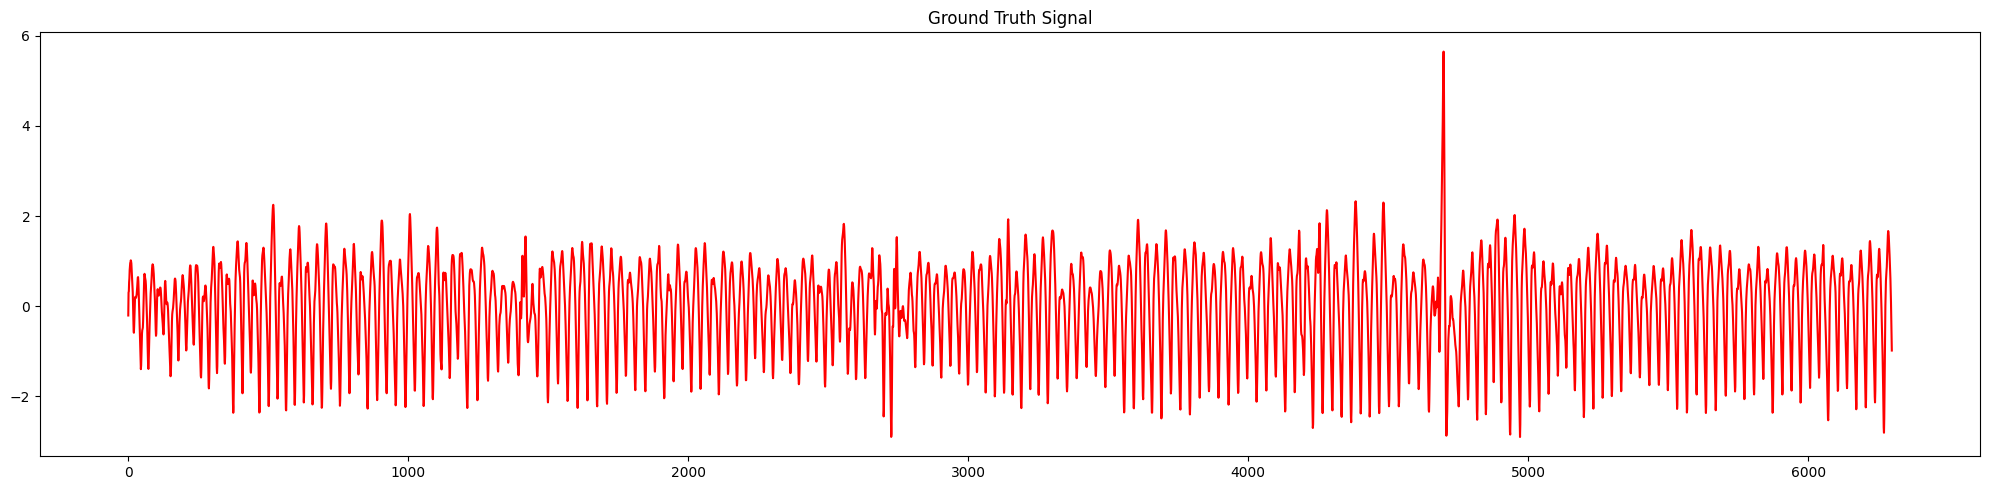

In [29]:
## Downsample Grond Truth Variable

# downsampled_ground_truth

## Plot the Ground Truth
plt.figure(figsize=(20, 5)) 
plt.plot(downsampled_ground_truth, color='red')
plt.title('Ground Truth Signal')
plt.tight_layout()
plt.show()


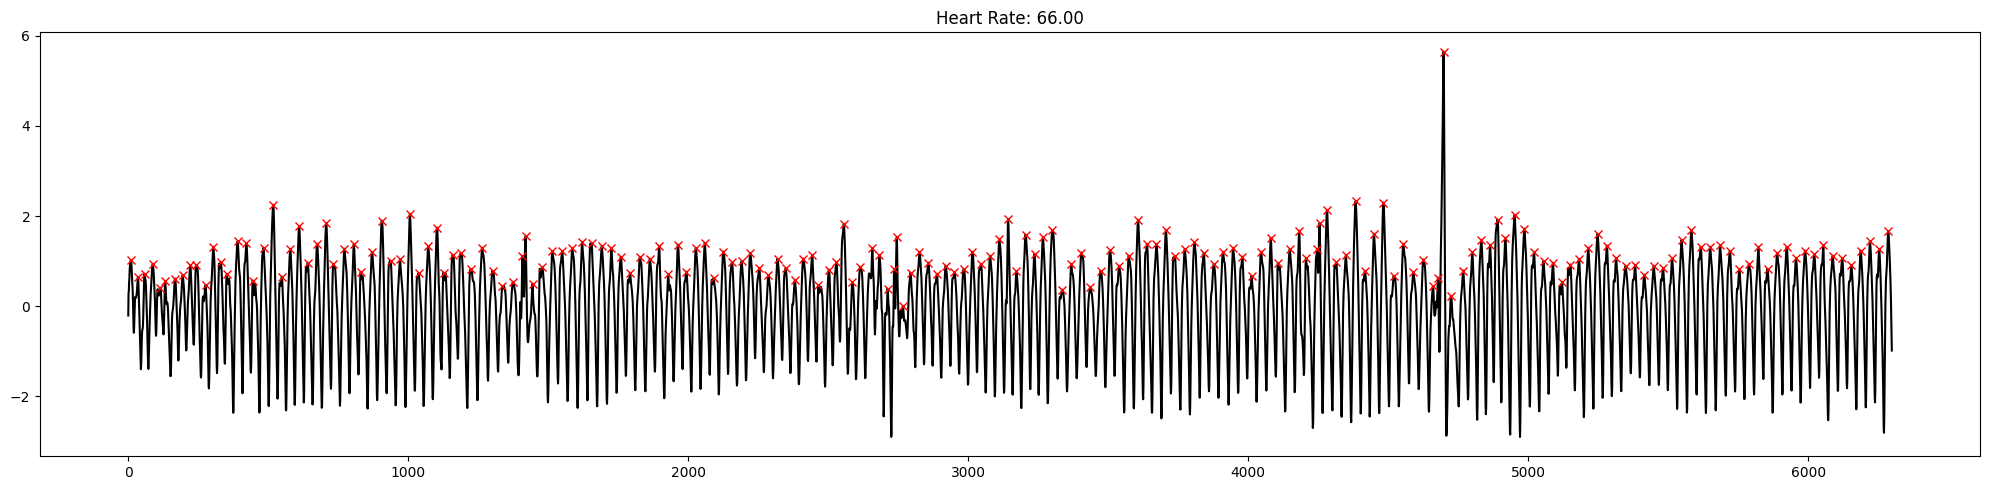

In [19]:
## Normalie the RPPG Signal
downsampled_ground_truth = (downsampled_ground_truth - np.mean(downsampled_ground_truth)) / np.std(downsampled_ground_truth)

## Finds Peak Signal
peaks, _ = signal.find_peaks(
    x=downsampled_ground_truth,
    prominence=0.5,
)

## Calculating the Heart Rate and Show the Result
heart_rate = 60 * len(peaks) / (len(downsampled_ground_truth) / fs)

plt.figure(figsize=(20, 5))
plt.plot(downsampled_ground_truth, color='black')
plt.plot(peaks, downsampled_ground_truth[peaks], 'x', color='red')
plt.title(f'Heart Rate: {heart_rate:.2f}')
plt.tight_layout()
plt.show()

### One Method, filter the Ground Truth

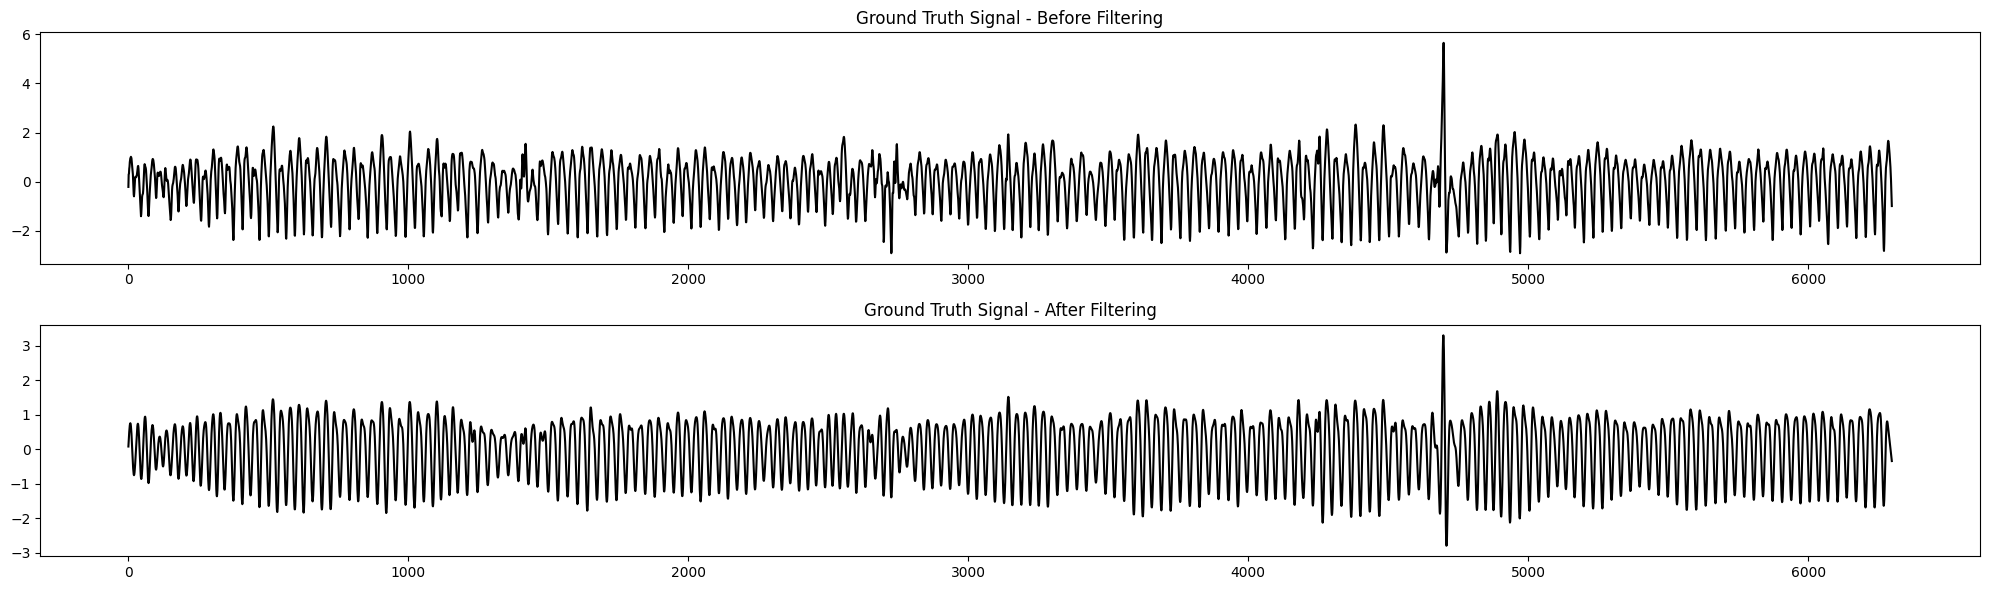

In [42]:
## Filter Original Length Signal
fs = 35; lowcut = 0.9; highcut = 2.4; order = 3
b, a = signal.butter(order, [lowcut, highcut], btype='band', fs=fs)
compressed_filtered_ground_truth = signal.filtfilt(b, a, downsampled_ground_truth)

## Show the Filtered RPPG Signal
fig, ax = plt.subplots(2, 1, figsize=(20, 6))
ax[0].plot(downsampled_ground_truth, color='black')
ax[0].set_title('Ground Truth Signal - Before Filtering')
ax[1].plot(compressed_filtered_ground_truth, color='black')
ax[1].set_title('Ground Truth Signal - After Filtering')
plt.tight_layout()
plt.show()

### Normalize and Finds Peak as the Heart Rate (QRS Complex)

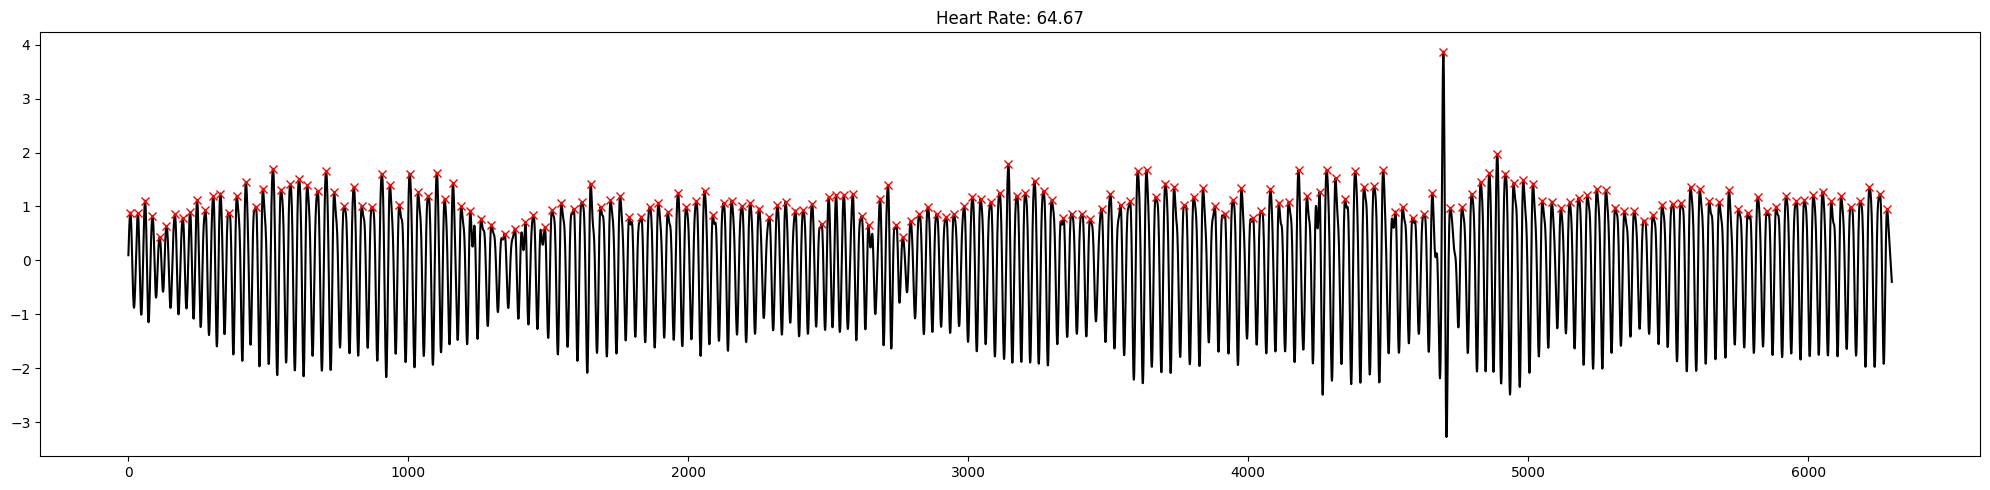

In [43]:
## Normalie the RPPG Signal
compressed_filtered_ground_truth = (compressed_filtered_ground_truth - np.mean(compressed_filtered_ground_truth)) / np.std(compressed_filtered_ground_truth)

## Finds Peak Signal
peaks, _ = signal.find_peaks(
    x=compressed_filtered_ground_truth,
    prominence=0.5,
)

## Calculating the Heart Rate and Show the Result
heart_rate = 60 * len(peaks) / (len(compressed_filtered_ground_truth) / fs)

plt.figure(figsize=(20, 5))
plt.plot(compressed_filtered_ground_truth, color='black')
plt.plot(peaks, compressed_filtered_ground_truth[peaks], 'x', color='red')
plt.title(f'Heart Rate: {heart_rate:.2f}')
plt.tight_layout()
plt.show()

---
Override Ground Truth and RPPG Signal are somehow not align, let's do the Frequency Analysis.

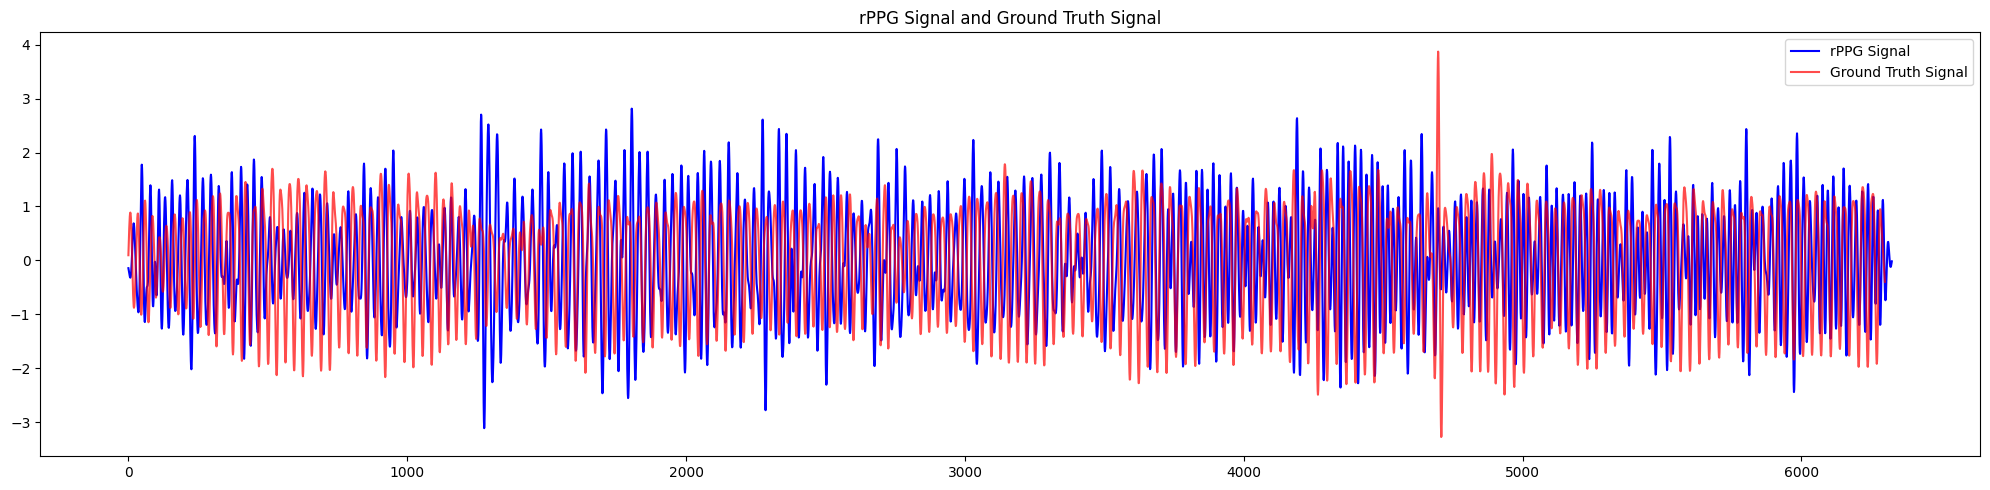

In [44]:
plt.figure(figsize=(20, 5))

# Plot rPPG signal
plt.plot(filtered_rppg, color='blue', label='rPPG Signal')

# Plot ground truth signal
plt.plot(compressed_filtered_ground_truth, color='red', alpha=0.7, label='Ground Truth Signal')

plt.title('rPPG Signal and Ground Truth Signal')
plt.legend()

plt.tight_layout()
plt.show()

---
Frequency Analysis on Both Signal

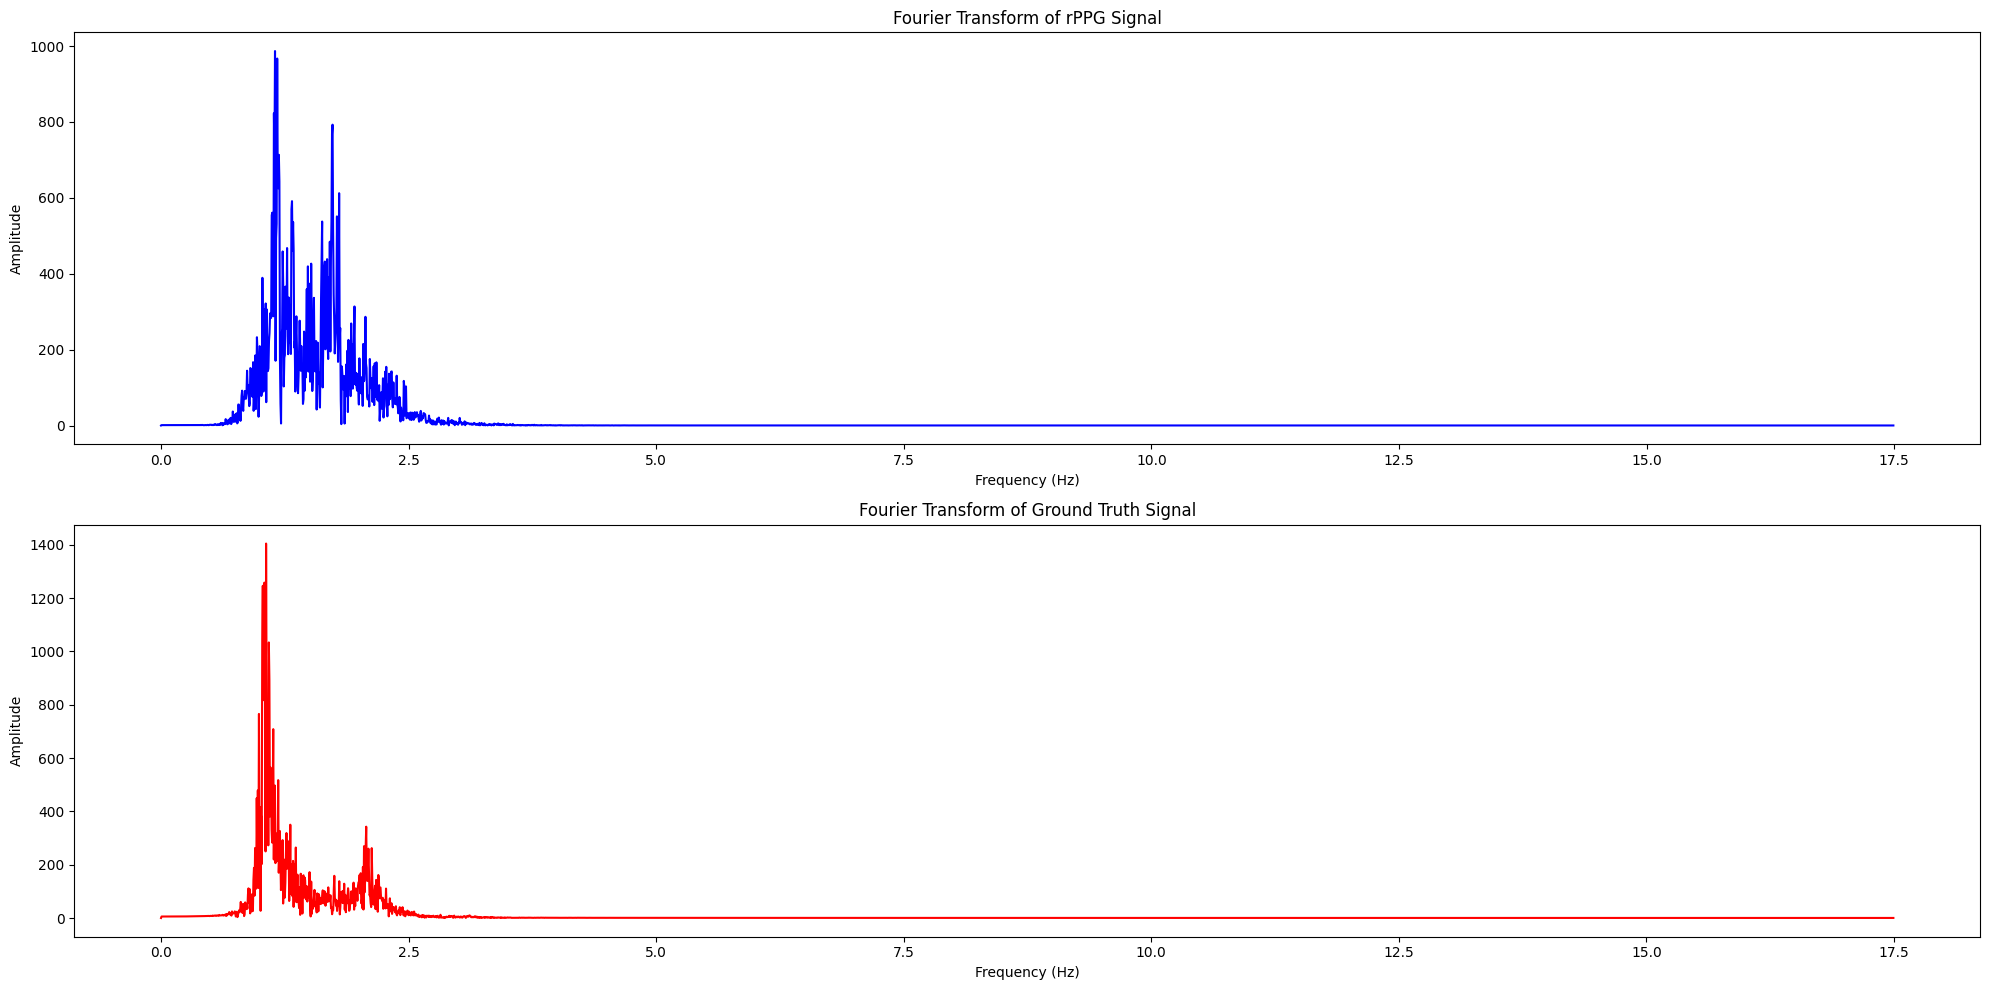

In [38]:
# Perform Fourier Transform on rPPG signal
rppg_freq = np.fft.fftfreq(len(filtered_rppg), d=1/fs)
rppg_fft = np.fft.fft(filtered_rppg)

# Perform Fourier Transform on ground truth signal
gt_freq = np.fft.fftfreq(len(compressed_filtered_ground_truth), d=1/fs)
gt_fft = np.fft.fft(compressed_filtered_ground_truth)

# Plot the Fourier Transforms
fig, ax = plt.subplots(2, 1, figsize=(20, 10))

# Plot rPPG signal Fourier Transform
ax[0].plot(rppg_freq[:len(rppg_freq)//2], np.abs(rppg_fft)[:len(rppg_fft)//2], color='blue')
ax[0].set_title('Fourier Transform of rPPG Signal')
ax[0].set_xlabel('Frequency (Hz)')
ax[0].set_ylabel('Amplitude')

# Plot ground truth signal Fourier Transform
ax[1].plot(gt_freq[:len(gt_freq)//2], np.abs(gt_fft)[:len(gt_fft)//2], color='red')
ax[1].set_title('Fourier Transform of Ground Truth Signal')
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Amplitude')

plt.tight_layout()
plt.show()